# 决策树

In [46]:
import numpy as np
import pandas as pd
import math

def stg_agg(n, c1, c2):
    return math.sqrt((c2/ n) - (c1 / n)**2)

class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=2):
        if idxs is None:
            idxs = np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf = x, y, idxs, min_leaf
        
        # n个数，c列的个数
        self.n, self.c = len(idxs), x.shape[1]
        # 在idxs的均值
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c):
            self.find_better_split(i)
            
        if self.score == float('inf'):
            return
        
        x = self.split_col
        # 获取左右子树的索引
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])
        
    def find_better_split(self, var_idx):
        # var_idx：第var_idx个特征， idx横坐标
        x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
        # 获取排序后的索引值
        sort_idx = np.argsort(x)
        # 获取排序之后的值
        sort_x, sort_y = x[sort_idx], y[sort_idx]
        # 一开始全是右子树
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.
        
        # 一个一个分给左子树
        for i in range(0, self.n - self.min_leaf - 1): # 保证右子树最少min_leaf个结点
            xi, yi = sort_x[i], sort_y[i]
            rhs_cnt -= 1; lhs_cnt += 1
            rhs_sum -= yi; lhs_sum += yi
            rhs_sum2 -= yi**2; lhs_sum2 += yi**2
            # 当左子树结点小于min_leaf，或者xi == x[i+1]则不进行划分了
            if i < self.min_leaf or xi == sort_x[i+1]:
                continue
            # 划分标准
            lhs_std = stg_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = stg_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_cnt*rhs_std
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi
                
    @property
    def split_name(self): 
        return self.x.columns[self.var_idx]
    
    @property
    def split_col(self):
        return self.x.values[self.idxs, self.var_idx]
    
    # 判断本决策树是否是叶子节点，则此时self.var是叶子节点的值，其他情况是均值
    @property
    def is_leaf(self): 
        return self.score == float('inf')
    
    # 输出对象的格式
    def __repr__(self):
        s = f'n:{self.n}; var:{self.var}'
        if not is_leaf():
            s = f'score:{self.score}; split:{self.split}; var:{self.var}'
        return s
    
    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])
    
    def predict_row(self, xi):
        if is_leaf:
            return self.var
        t = self.lhs if xi[self.var_idx] < self.split else self.rhs
        return t.predict_row(xi)

Text(0, 0.5, 'y')

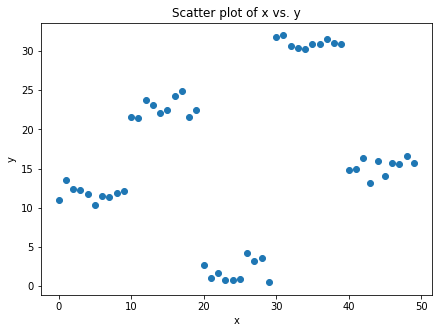

In [35]:
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline


x = np.arange(0,50)
x = pd.DataFrame({'x':x})

y1 = np.random.uniform(10,15,10)
y2 = np.random.uniform(20,25,10)
y3 = np.random.uniform(0,5,10)
y4 = np.random.uniform(30,32,10)
y5 = np.random.uniform(13,17,10)

y = np.concatenate((y1,y2,y3,y4,y5))
y = y[:,None] 

plt.figure(figsize=(7,5))
plt.plot(x,y, 'o')
plt.title("Scatter plot of x vs. y")
plt.xlabel("x")
plt.ylabel("y") 

In [ ]:
xi = x # initialization of input
yi = y # initialization of target
# x,y --> use where no need to change original y
ei = 0 # initialization of error
n = len(yi)  # number of rows
predf = 0 # initial prediction 0

for i in range(30): # like n_estimators
    tree = DecisionTree(xi,yi)
    tree.find_better_split(0)
    
    r = np.where(xi == tree.split)[0][0]    
    
    left_idx = np.where(xi <= tree.split)[0]
    right_idx = np.where(xi > tree.split)[0]
    
    predi = np.zeros(n)
    np.put(predi, left_idx, np.repeat(np.mean(yi[left_idx]), r))  # replace left side mean y
    np.put(predi, right_idx, np.repeat(np.mean(yi[right_idx]), n-r))  # right side mean y
    
    predi = predi[:,None]  # make long vector (nx1) in compatible with y
    predf = predf + predi  # final prediction will be previous prediction value + new prediction of residual
    
    ei = y - predf  # needed originl y here as residual always from original y    
    yi = ei # update yi as residual to reloop
    
    
    # plotting after prediction
    xa = np.array(x.x) # column name of x is x 
    order = np.argsort(xa)
    xs = np.array(xa)[order]
    ys = np.array(predf)[order]
    
    #epreds = np.array(epred[:,None])[order]

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (13,2.5))

    ax1.plot(x,y, 'o')
    ax1.plot(xs, ys, 'r')
    ax1.set_title(f'Prediction (Iteration {i+1})')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y / y_pred')

    ax2.plot(x, ei, 'go')
    ax2.set_title(f'Residuals vs. x (Iteration {i+1})')
    ax2.set_xlabel('x')
    ax2.set_ylabel('Residuals') 

# GBDT

而梯度提升树相关的模型，例如XGBoost，LightGBM，CatBoost等在建模的时候则往往不需要对特征进行归一化，对于特征中出现的极大极小值也有较好的鲁棒性<br>
- 传统的表格(Tabular)类模型，基于梯度提升树的模型往往可以取得更好的成绩，我们对这些历史竞赛进行了统计，发现对于表格型的数据算法竞赛，超过90%以上的获奖方案目前都都是基于梯度提升树模型的。目前有些特定的领域，例如推荐，销量预测等问题慢慢地神经网络也展露头角；
- 图像，NLP，序列化等非Tabular类的模型，Top的方案主要基于各种神经网络的；虽然早期也会有一些传统方案的，例如随机森林等，但是最近几年已经全部演化为了神经网络相关的模型。

因为我们的目标是最小化$L(y, F(x)$，那么我们只需要做到$L(y, \sum_{i=1}^t f_i(x) + f_{t+1}(x))$的值比$L(y, \sum_{i=1}^tf_i(x))$尽可能的小。<br>
此处我们进一步假设问题的$\color{red}{损失函数L是可导的}$，这个假设在目前的很多问题中都是非常通用的，毕竟目前的常用的损失函数一半以上都是可导的。<br>

即最大化$$max[L(y, \sum_{i=1}^t f_i(x) + f_{t+1}(x)) - L(y, \sum_{i=1}^tf_i(x))]$$
令$c = \sum_{i=1}^t f_i(x)$,则$$max[L(y, c + f_{t+1}(x)) - L(y, c)]$$
根据泰勒公式：$$L(c + f_{t+1}(x)) \approx L(c) + L^{'}(c)f_{t+1}(X)$$
若$f_{t+1}(x) = -1 * L^{'}(c)$,则大约$$L(c + f_{t+1}(x)) = L(c) - L^{'}(c)^2 < L(c)$$
所以用第t+1个决策树来拟合$f_{t+1}(x) = -1 * L^{'}(c)$，即拟合$\color{red}{梯度}$

In [1]:
import time 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import ensemble
from sklearn import datasets
from sklearn.model_selection import train_test_split
 
data_list  = [datasets.load_iris(), datasets.load_digits()]
data_list  = [(d.data, d.target) for d in data_list]
data_list += [datasets.make_hastie_10_2()]
names      = ['Iris Data', 'Digits Data', 'Hastie Data']

n_gb       = []
score_g    = []
time_gb    = [] 
score_gb   = [] 
n_estimators = 500

for X, y in data_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=0)
 
    gb = ensemble.GradientBoostingClassifier(n_estimators=n_estimators,random_state=0)
    gb.fit(X_train, y_train)
    score_gb.append(gb.score(X_test, y_test))  
    n_gb.append(gb.n_estimators_) 
print(score_gb) 

[1.0, 0.9583333333333334, 0.9504166666666667]
